In [1]:
import numpy as np 
import pandas as pd

%matplotlib inline

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.dates as mdates
import datetime

In [12]:
def plot_map(dataset, title, columns, save=False, show=True, minmax_list=None, min=None, max=None):
    """
    Plots each column of a Pandas DataFrame that contains the columns "Long"
    and "Lat" over a Earth map. Optionally saves the plot to disk or just
    displays the plot on the screen.

    :param dataset: pd.DataFrame
    :param title: Str. Dataset title
    :param save: Bool. Save the figure
    :param show: Bool. Show the plot
    :param minmax_list: List. Contains min and max of each graphic
    :param min: Float. Global min to set the colorbar range
    :param max: Float. Global max to set the colorbar range
    :return: None
    """
    # scales = [1, 1e9, 1e-9, 1e-9]
    # min, max = min[columns], max[columns]

    minmax_ind = 0

    for column in columns:
        data = dataset[column]
        #print(data.min())
        #print(data.max())
        # Set world axes
        fig = plt.figure(figsize=(1024 / 96, 768 / 96), dpi=96)
        ax = plt.axes(projection=ccrs.PlateCarree())
        #ax.coastlines()
        ax.stock_img()
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=1, color='gray', alpha=0.5,
                          linestyle='--')
        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER

        # Plot certain places as black triangles
        plt.scatter(-76.704, -11.739, c="k", marker="^",s=4)  # Jicamarca, Peru
        plt.scatter(-71.488, 42.623, c="k", marker="^", s=4)  # MIT Haystack, EEUU
        plt.scatter(-66.752, 18.344, c="k", marker="^", s=4)  # Arecibo, Puerto Rico
        plt.scatter(-94.829, 74.697, c="k", marker="^", s=4)  # Resolute Bay, Canada
        plt.scatter(-147.488, 65.125, c="k", marker="^", s=4)  # Poker Flat, Alaska

        plt.title(column + "\n" + "".join(title))

        # Plot as scatter
        plt.scatter(dataset["Lon"], dataset["Lat"], c=dataset[column], s=20, cmap="plasma", alpha=0.5, linewidths=0, edgecolors=None)
        colorbar = plt.colorbar()
        colorbar.set_label(column)

        # Set colorbar scale
        if minmax_list:
            plt.clim(minmax_list[minmax_ind * 2], minmax_list[minmax_ind * 2 + 1])
            minmax_ind+=1

        # Finally plot
        if save:
            plt.savefig("".join(title) + "-" + column + ".png", dpi=96)
        if show:
            plt.show()

        plt.close()

In [96]:
def plot_lat_in_time(dataset, threshold, title, save=False, show=True):

    # time column as datetime
    #dataset['time'] = pd.to_datetime(dataset['time'], format='%Y-%m-%d %H:%M:%S')

    # sort dataset by time
    dataset = dataset.sort_values(by=['time'])

    # make columns
    lat = dataset["Lat"]
    time = dataset["time"]

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))

    # plot
    blue_data = dataset.loc[dataset['day'] == 0]
    lat_blue = blue_data["Lat"]
    time_blue = blue_data["time"]

    red_data = dataset.loc[dataset['day'] == 1]
    lat_red = red_data["Lat"]
    time_red = red_data["time"]

    # if not blue_data.empty:
    plt.plot(time_blue, lat_blue, 'ro', markersize=0.5, color='blue')
    # if not red_data.empty:
    plt.plot(time_red, lat_red, 'ro', markersize=0.5, color='red')

    # beautify the x-labels
    plt.gcf().autofmt_xdate()
    # _ = plt.xticks(rotation=90)

    # set y axis range and grid
    plt.ylim((-90, 90))
    ax = plt.gca()
    ax.yaxis.grid(True)

    # set labels and title
    plt.xlabel("Time (Y-m-d H:M:S)")
    plt.ylabel("Latitude")
    plt.title("Time vs. Latitude")

    # Finally plot
    if save:
        plt.savefig("".join(title) + "-Lat" + ".png", dpi=96)
    if show:
        plt.show()

    plt.close()
    
def make_in_max_out(dataset):
    dataset_aux = dataset.loc[dataset['group'] != 0]
    idx_max = dataset_aux.groupby(['group'])['Particles counter'].transform(max) == dataset_aux['Particles counter']
    idx_first = dataset_aux.groupby(['group'])['Particles counter'].transform('first') == dataset_aux['Particles counter']
    idx_last = dataset_aux.groupby(['group'])['Particles counter'].transform('last') == dataset_aux['Particles counter']
    dataset_aux = pd.concat([dataset_aux[idx_max], dataset_aux[idx_first], dataset_aux[idx_last]])
    result = dataset_aux.sort_values(['group']).reset_index()
    #save_as_csv(result, 'anomalies_in_max_out.csv')
    result.set_index("time", drop=False, inplace=True)
    result.index.set_names("index", inplace=True)
    return result

# SUCHAI-1 Langmuir probe's particles counter analysis

## Read datafile
We are using **Pandas** to process the datafiles. Please refer to the [Pandas documentation](http://pandas.pydata.org/pandas-docs/stable/10min.html) for more details about how to use this library.

In [59]:
# Read datafile
df = pd.read_csv("../langmuir-2018.csv", delimiter='\t')
df["time"] = pd.DatetimeIndex(df.time)
df.set_index("time", inplace=True)
df.describe()

,Unnamed: 0,Sweep voltage,Plasma voltage,Plasma temperature,Particles counter,Lon,Lat,Plasma current,Electron density 300K,Electron density 3000K,day,is_anom,anom_diff,group,SEASON
count,15887.000000,15887.000000,15887.000000,15887.000000,15887.000000,15887.000000,15887.000000,1.588700e+04,1.588700e+04,1.588700e+04,15887.000000,15887.000000,15887.000000,15887.000000,15887.000000
mean,7943.000000,4.009846,2.187181,294.063773,65.357651,20.312501,0.666809,2.964614e-08,2.375733e+10,7.512728e+09,0.509221,0.031283,0.000063,1.507711,1.712847
std,4586.326199,0.008472,0.584082,2.961023,288.206156,100.462047,50.837754,3.539236e-08,2.836214e+10,8.968896e+09,0.499931,0.174088,0.110223,9.665971,0.612925
min,0.000000,3.944212,0.000000,286.896250,0.000000,-179.999896,-82.597286,8.055833e-12,6.455650e+06,2.041456e+06,0.000000,0.000000,-1.000000,0.000000,1.000000
25%,3971.500000,4.002862,1.720400,291.295000,1.000000,-60.161122,-44.042882,2.820896e-09,2.260562e+09,7.148526e+08,0.000000,0.000000,0.000000,0.000000,1.000000
50%,7943.000000,4.007750,2.287350,294.227500,5.000000,2.712438,1.116077,1.448194e-08,1.160530e+10,3.669918e+09,1.000000,0.000000,0.000000,0.000000,2.000000
75%,11914.500000,4.017525,2.693013,296.671250,10.000000,117.525221,45.686758,4.674272e-08,3.745790e+10,1.184523e+10,1.000000,0.000000,0.000000,0.000000,2.000000
max,15886.000000,4.046850,3.245300,302.536250,3371.000000,179.989350,82.597280,3.062319e-07,2.454030e+11,7.760325e+10,1.000000,1.000000,1.000000,97.000000,3.000000


## Scatter plot of the anomaly
### We can apply some filters to the data

1. Filter by some column values
2. Filter by date (we set the "time" column as an index)

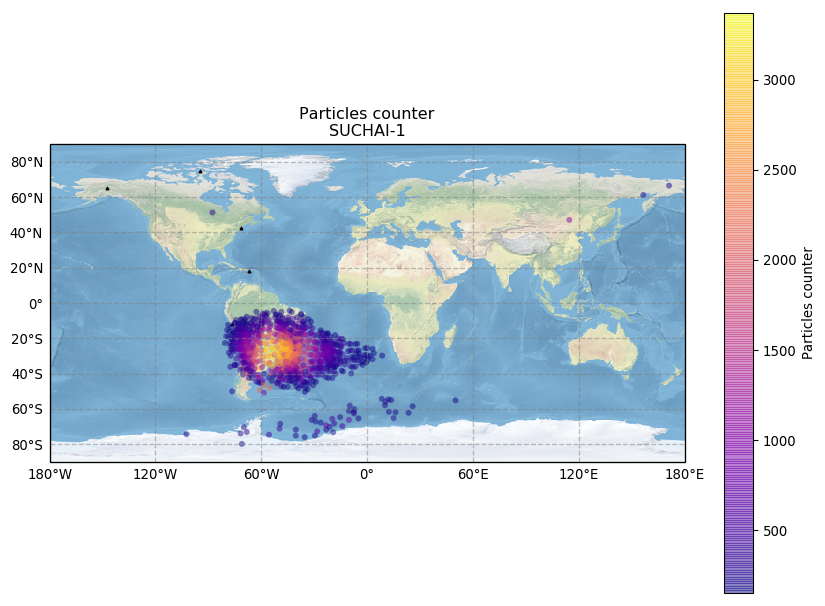

In [45]:
# Filter by value
df_f = df[df["Particles counter"] > 150]
plot_map(df_f, "SUCHAI-1", ["Particles counter"])

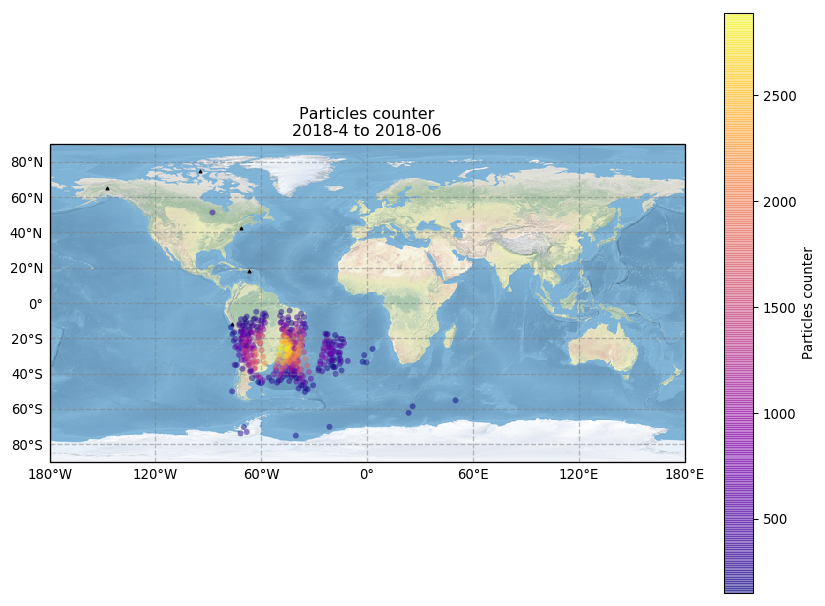

In [55]:
# Filter by date
## April - June
df_f = df["2018-04-01":"2018-07-01"]
df_f = df_f[df_f["Particles counter"] > 150]
plot_map(df_f, "2018-4 to 2018-06", ["Particles counter"])

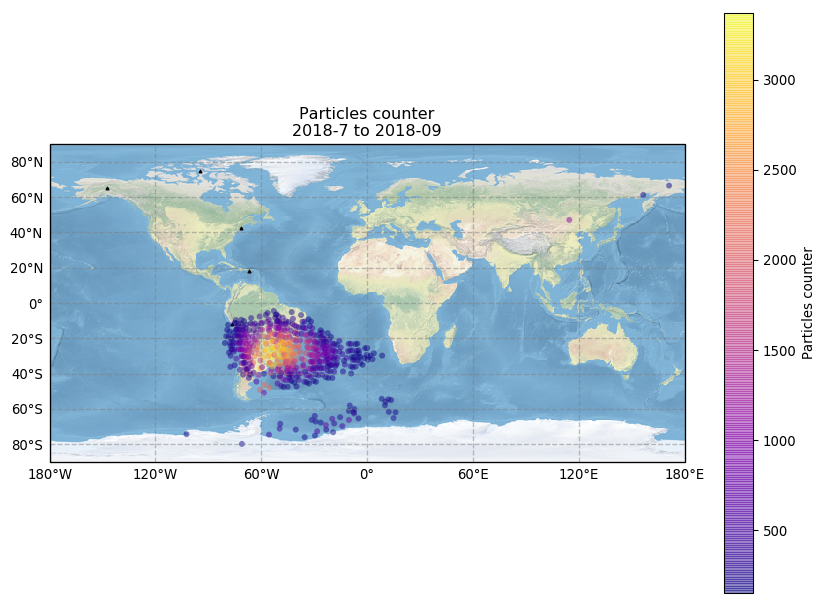

In [74]:
# Filter by date
## July - September
df_f = df["2018-7-1":"2018-12-1"]
df_f = df_f[df_f["Particles counter"] > 150]
plot_map(df_f, "2018-7 to 2018-09", ["Particles counter"])


## Plot max and min values inside the anomaly

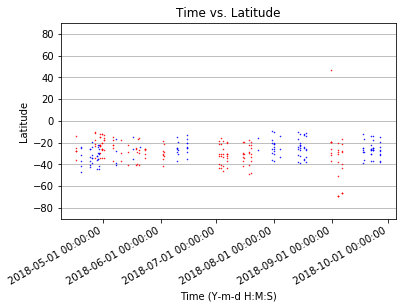

In [100]:
%matplotlib inline
# First, filter the samples in, out and max of the anomaly
df_f = make_in_max_out(df)

# Some filters? Uncomment 
#df_f = df_f["2018-4-1":"2018-07-1"]

# Plot this new filtered dataframe
plot_lat_in_time(df_f, 600, 'Latitud')

,time,Unnamed: 0,header,Sweep voltage,Plasma voltage,Plasma temperature,Particles counter,Lon,Lat,Plasma current,Electron density 300K,Electron density 3000K,day,is_anom,anom_diff,group,SEASON
time,,,,,,,,,,,,,,,,,
2018-04-16 10:28:56,2018-04-16 10:28:56,3,0x43434305,4.017525,2.414425,297.16000,601,-18.285970,-27.565981,3.160938e-08,2.533060e+10,8.010238e+09,1,1,1.0,1,1
2018-04-16 10:28:56,2018-04-16 10:28:56,3,0x43434305,4.017525,2.414425,297.16000,601,-18.285970,-27.565981,3.160938e-08,2.533060e+10,8.010238e+09,1,1,1.0,1,1
2018-04-16 10:28:56,2018-04-16 10:28:56,3,0x43434305,4.017525,2.414425,297.16000,601,-18.285970,-27.565981,3.160938e-08,2.533060e+10,8.010238e+09,1,1,1.0,1,1
2018-04-16 12:02:56,2018-04-16 12:02:56,97,0x43434305,4.007750,2.526838,295.69375,2453,-41.369503,-24.994031,3.887375e-08,3.115200e+10,9.851126e+09,1,1,0.0,2,1
2018-04-16 12:05:56,2018-04-16 12:05:56,100,0x43434305,4.017525,2.346000,296.18250,863,-44.116311,-36.263325,2.281491e-08,1.828303e+10,5.781603e+09,1,1,0.0,2,1
2018-04-16 11:59:56,2018-04-16 11:59:56,94,0x43434305,4.017525,2.761437,295.20500,900,-38.962319,-13.702032,7.851866e-08,6.292198e+10,1.989768e+10,1,1,1.0,2,1
2018-04-19 00:33:14,2018-04-19 00:33:14,233,0x43434305,4.002862,1.534675,297.64875,2336,-40.884471,-31.650325,1.992923e-09,1.597056e+09,5.050334e+08,0,1,0.0,3,1
2018-04-19 00:35:14,2018-04-19 00:35:14,235,0x43434305,4.012638,1.476025,297.64875,995,-42.642514,-24.124112,1.646861e-09,1.319734e+09,4.173366e+08,0,1,0.0,3,1
2018-04-19 00:29:14,2018-04-19 00:29:14,229,0x43434305,4.002862,1.627538,299.60375,622,-36.567757,-46.648027,3.361196e-09,2.693539e+09,8.517718e+08,0,1,1.0,3,1
